CREDIT RISK ANALYSIS

This project aims to predict the probability of loan default using historical loan application data.
By analyzing borrower characteristics (like age, income, employment, and credit history), the model helps financial institutions assess creditworthiness and manage risk exposure.

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the dataset
df = pd.read_csv("credit_risk_dataset.csv")
print(f"Data Shape: {df.shape}")
print(df.head())


Data Shape: (32581, 12)
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y       

In [3]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [4]:
# Data Cleaning
# Standardize column names
df.columns = df.columns.str.lower().str.strip()
df.head()



,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
# Check number of records before removing duplicates
before = df.shape[0]
print(f"Records before: {before}")

Records before: 32581


In [6]:
# Remove duplicates
df = df.drop_duplicates()

# Show number of records after removing duplicates
after = df.shape[0]
removed = before - after

print(f"\n Duplicate Removal Summary:")
print(f"Records before: {before}")
print(f"Records after : {after}")
print(f"Duplicates removed: {removed}")


 Duplicate Removal Summary:
Records before: 32581
Records after : 32416
Duplicates removed: 165


In [7]:
# Inspect missing values BEFORE handling
print("\n Missing Values Count (Before Handling):")
print(df.isnull().sum())

print("\n Missing Values Percentage:")
missing_percent = (df.isnull().mean() * 100).round(2)
print(missing_percent[missing_percent > 0])


 Missing Values Count (Before Handling):
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

 Missing Values Percentage:
person_emp_length    2.74
loan_int_rate        9.55
dtype: float64


In [9]:
# Handle Missing Values

# Separate numeric & categorical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

print("\n Numeric Columns:", num_cols)
print(" Categorical Columns:", cat_cols)

# Initialize imputers
# Numeric with median and categorical with most frequent value
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# Fit & transform data
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Verify that missing values are handle

print("\n Missing Value Check After Imputation:")
print(df.isnull().sum())

total_missing = df.isnull().sum().sum()
print(f"\n Total Missing Values Remaining: {total_missing}")

# STEP 5 — Basic Clean Data Summary
print("\n Data Cleaning completed successfully!")
print("\n Clean Dataset Overview:")
print(f"Shape after cleaning: {df.shape}\n")
print(df.info())
print("\n Sample Rows After Cleaning:")
print(df.head())



 Numeric Columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']
 Categorical Columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

 Missing Value Check After Imputation:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

 Total Missing Values Remaining: 0

 Data Cleaning completed successfully!

 Clean Dataset Overview:
Shape after cleaning: (32416, 12)

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Coun

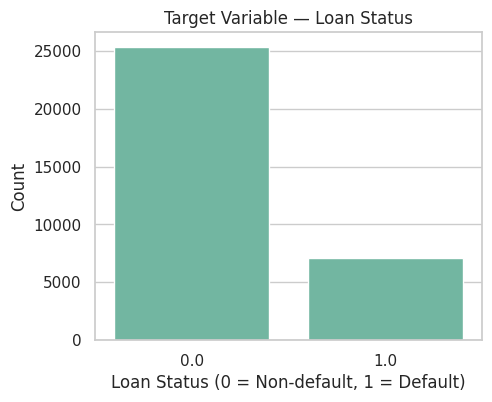


 Target Value Counts:
loan_status
0.0    25327
1.0     7089
Name: count, dtype: int64

 Target Value Percentages:
loan_status
0.0    78.13%
1.0    21.87%
Name: proportion, dtype: object


In [10]:
# Exploratory Data Analysis (EDA)

sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (8, 4)

# Target Variable Distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='loan_status', data=df)
plt.title("Target Variable — Loan Status")
plt.xlabel("Loan Status (0 = Non-default, 1 = Default)")
plt.ylabel("Count")
plt.show()

print("\n Target Value Counts:")
print(df['loan_status'].value_counts())
print("\n Target Value Percentages:")
print(df['loan_status'].value_counts(normalize=True).map("{:.2%}".format))

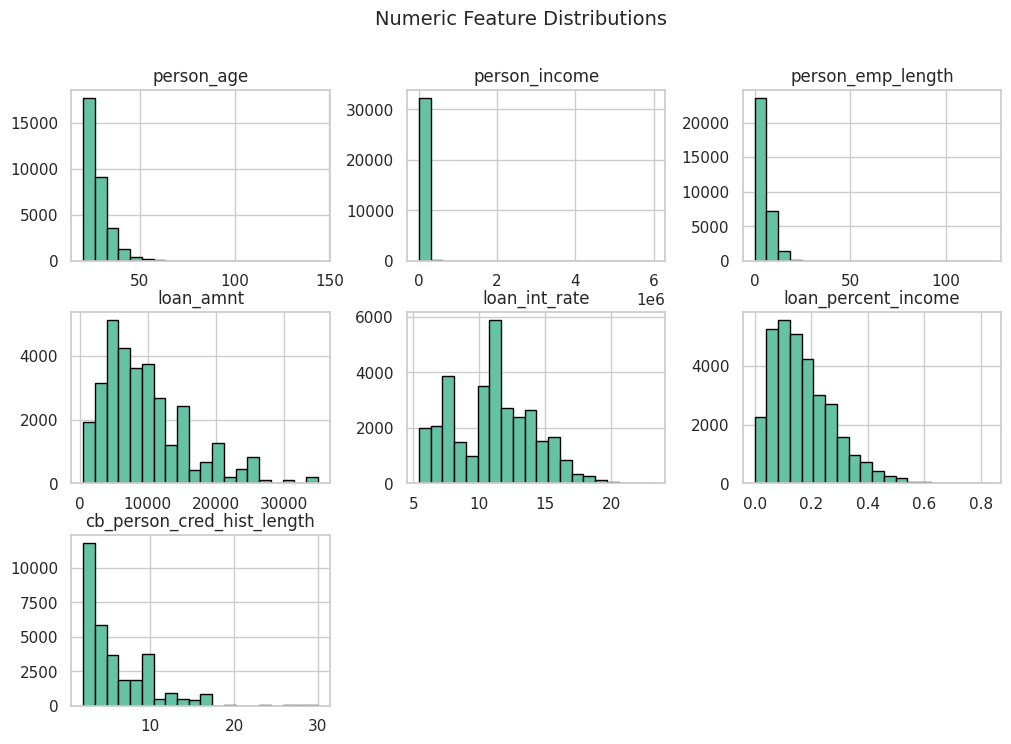

In [12]:
# Numeric Feature Distributions -----
num_cols = [col for col in df.select_dtypes(include=np.number).columns if col != 'loan_status']

df[num_cols].hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Numeric Feature Distributions", fontsize=14)
plt.show()

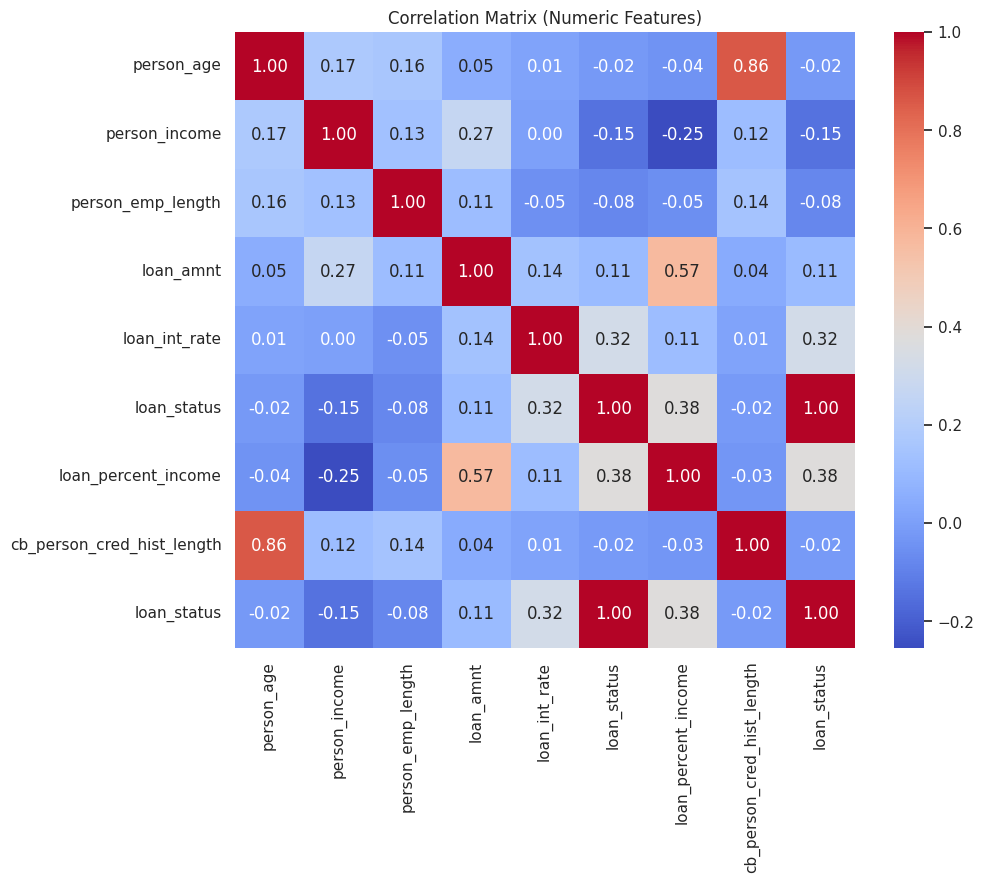

In [11]:
# Correlation Matrix
corr = df[num_cols + ['loan_status']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

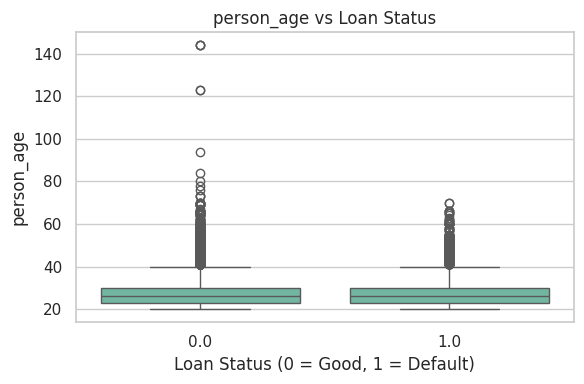

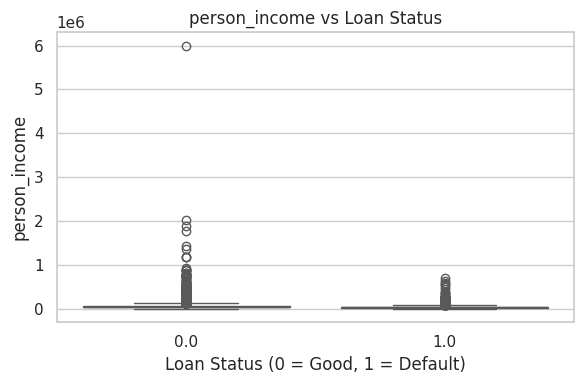

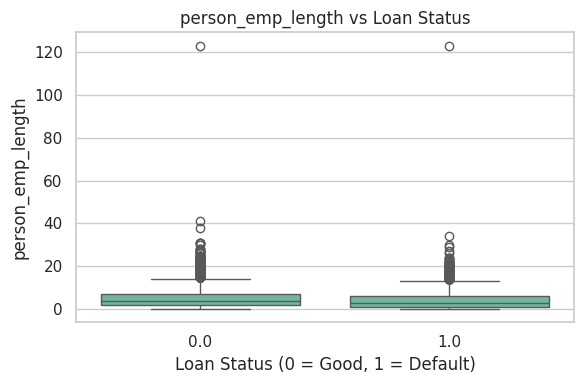

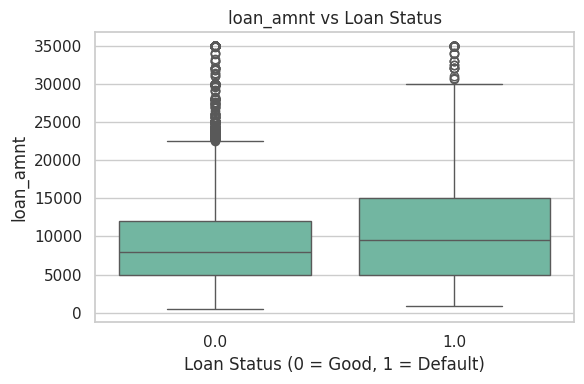

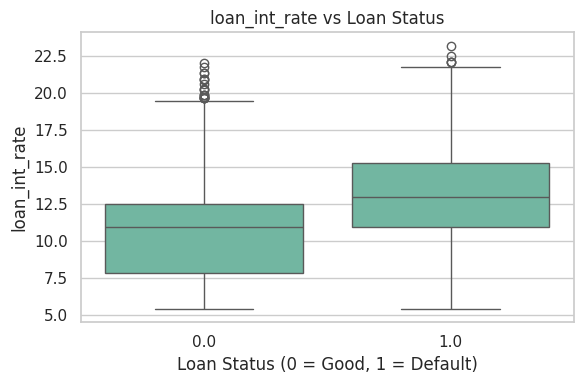

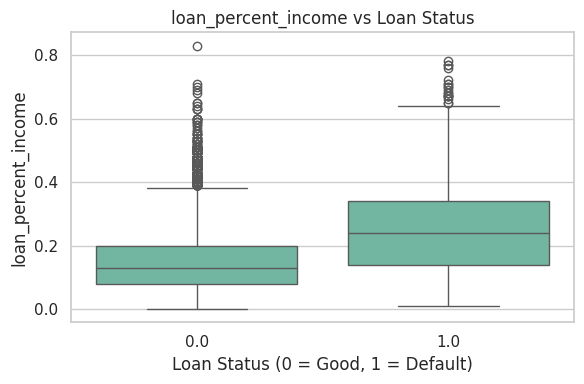

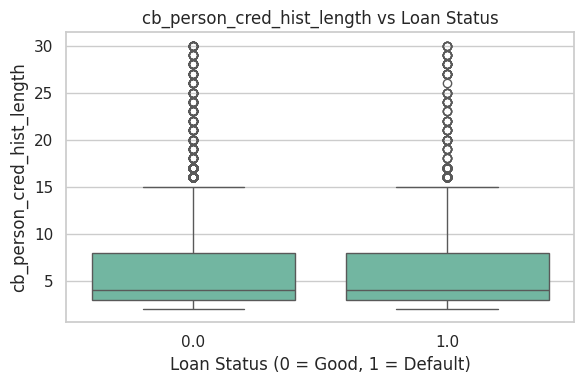

In [14]:
# Boxplots: Relationship between Numeric Features & Target
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='loan_status', y=col, data=df)
    plt.title(f"{col} vs Loan Status")
    plt.xlabel("Loan Status (0 = Good, 1 = Default)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

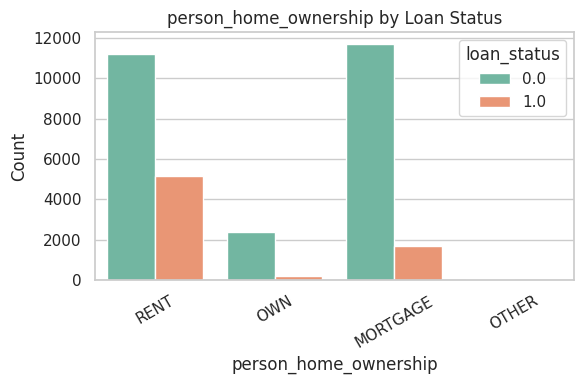

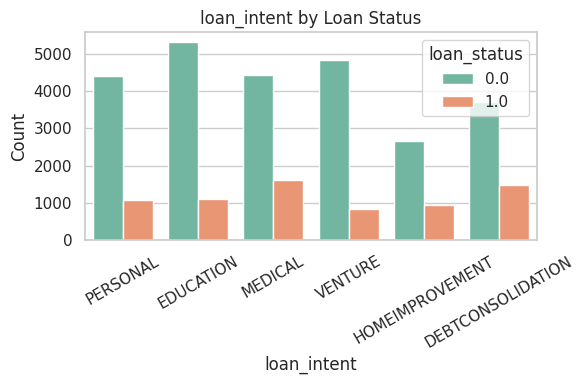

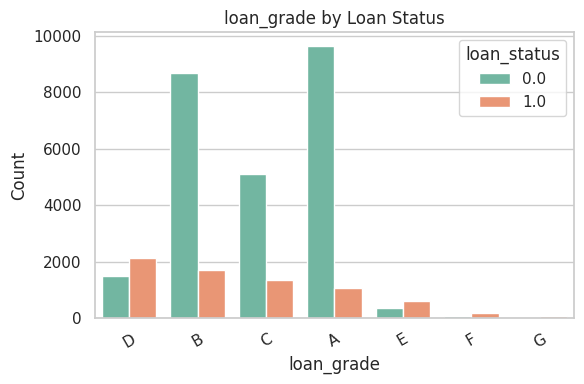

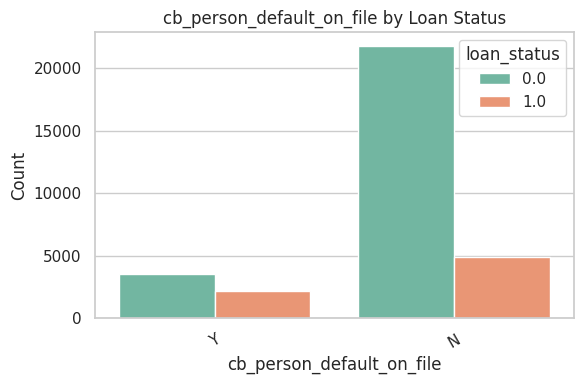

In [15]:
# Relationship between Categorical Features & Target
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='loan_status', data=df)
    plt.title(f"{col} by Loan Status")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


In [16]:
# Quick Summary
print("\n EDA completed successfully!")
print(f"Total numeric features: {len(num_cols)}")
print(f"Total categorical features: {len(cat_cols)}")



 EDA completed successfully!
Total numeric features: 7
Total categorical features: 4


In [17]:

# Feature Engineering
# added new features income_to_loan & emp_age_ratio
# this ratios helps to represent financial leverage and emplymnet stability realtive to age

# Example engineered features
df['income_to_loan'] = df['person_income'] / (df['loan_amnt'] + 1)
df['emp_age_ratio'] = df['person_emp_length'] / (df['person_age'] + 1)

print("Engineered Features Added: ['income_to_loan', 'emp_age_ratio']")
print(df[['person_income', 'loan_amnt', 'person_emp_length', 'person_age', 'income_to_loan', 'emp_age_ratio']].head())


Engineered Features Added: ['income_to_loan', 'emp_age_ratio']
   person_income  loan_amnt  person_emp_length  person_age  income_to_loan  \
0        59000.0    35000.0              123.0        22.0        1.685666   
1         9600.0     1000.0                5.0        21.0        9.590410   
2         9600.0     5500.0                1.0        25.0        1.745137   
3        65500.0    35000.0                4.0        23.0        1.871375   
4        54400.0    35000.0                8.0        24.0        1.554241   

   emp_age_ratio  
0       5.347826  
1       0.227273  
2       0.038462  
3       0.166667  
4       0.320000  


In [20]:

# Split Data (Train / Validation / Test

from sklearn.model_selection import train_test_split

X = df.drop('loan_status', axis=1)
y = df['loan_status']

# 70% train, 15% valid, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Split Summary:")
print(f"Train: {X_train.shape}, Validation: {X_valid.shape}, Test: {X_test.shape}")



Split Summary:
Train: (22691, 13), Validation: (4862, 13), Test: (4863, 13)


In [21]:
# Preprocessing Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separate numeric and categorical features
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

# # StandardScaler transforms numerical features so that they have
#  Mean = 0 & Standard deviation = 1
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

# OneHotEncoder converts categorical features (e.g., loan intent, home ownership, loan grade) into binary indicator variables.
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

print(f"\n Preprocessing Pipeline Summary:")
print(f"Numeric Columns: {num_cols}")
print(f"Categorical Columns: {cat_cols}")


 Preprocessing Pipeline Summary:
Numeric Columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'income_to_loan', 'emp_age_ratio']
Categorical Columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [22]:
#  Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

# Logistic Regression → Baseline, interpretable, simple, linear
# Logistic Regression Pipeline
log_reg = Pipeline([
    ('pre', preprocessor),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

# Gradient Boosting → Advanced, powerful, non-linear, robust
# Gradient Boosting Pipeline
hgb = Pipeline([
    ('pre', preprocessor),
    ('model', HistGradientBoostingClassifier(
        learning_rate=0.05, max_leaf_nodes=31,
        min_samples_leaf=50, early_stopping=True))
])



In [23]:
# Model Training
print("\n Training Logistic Regression...")
log_reg.fit(X_train, y_train)

print(" Training Gradient Boosting...")
hgb.fit(X_train, y_train)



 Training Logistic Regression...
 Training Gradient Boosting...


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length',
                                                   'income_to_loan',
                                                   'emp_age_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                learning_rate=0.05,
                                                min_samples_leaf=50))])

In [24]:
# Model Evaluation
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt


Why ROC-AUC is used here:
- Credit risk datasets are often imbalanced (more non-defaults than defaults).
- ROC-AUC evaluates the model’s ability to rank positive cases higher than negatives, independent of class imbalance or chosen cutoff.
- Provides a single score summarizing model discrimination power.
- In this project:
   - ROC-AUC is used to compare Logistic Regression and Gradient Boosting models.
   - Higher AUC → Better ability to correctly rank risky borrowers above safe ones.


In [25]:
# Logistic Regression Predictions
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]
log_reg_auc = roc_auc_score(y_test, log_reg_pred)

# Gradient Boosting Predictions
hgb_pred = hgb.predict_proba(X_test)[:, 1]
hgb_auc = roc_auc_score(y_test, hgb_pred)

print(f"\n Logistic Regression Test ROC-AUC: {log_reg_auc:.4f}")
print(f" Gradient Boosting Test ROC-AUC: {hgb_auc:.4f}")



 Logistic Regression Test ROC-AUC: 0.8738
 Gradient Boosting Test ROC-AUC: 0.9440


In [26]:
# Choose the better model
best_model = hgb if hgb_auc > log_reg_auc else log_reg
best_name = "Gradient Boosting" if best_model is hgb else "Logistic Regression"
print(f"\n Best model: {best_name}")



 Best model: Gradient Boosting


In [27]:
# Confusion matrix and classification report
y_pred_class = (best_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
print("\n Confusion Matrix:\n", cm)
print("\n Classification Report:\n", classification_report(y_test, y_pred_class))



 Confusion Matrix:
 [[3779   20]
 [ 290  774]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3799
         1.0       0.97      0.73      0.83      1064

    accuracy                           0.94      4863
   macro avg       0.95      0.86      0.90      4863
weighted avg       0.94      0.94      0.93      4863



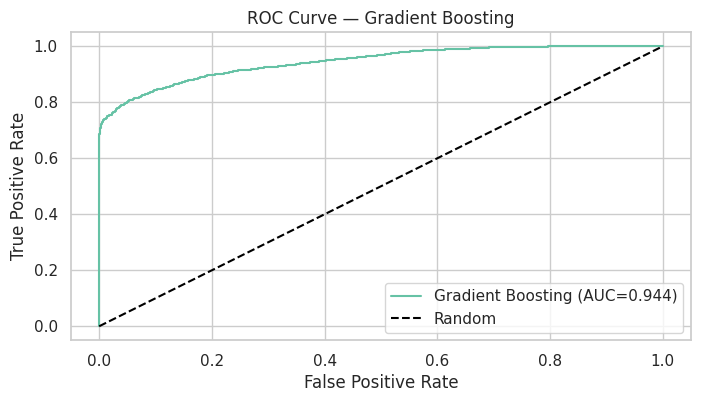

In [28]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'{best_name} (AUC={roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {best_name}")
plt.legend()
plt.show()


In [29]:
# STEP 13 — Save Best Model
from joblib import dump
dump(best_model, "credit_risk_model.joblib")
print(f"\n Saved best model ({best_name}) as 'credit_risk_model.joblib'")



 Saved best model (Gradient Boosting) as 'credit_risk_model.joblib'


In [30]:

#Testing new loan applications

import pandas as pd
from IPython.display import display  # enables nice HTML tables

import pandas as pd
from joblib import load
from IPython.display import display  # enables nice HTML tables

# STEP 1 — Load trained model
model = load("credit_risk_model.joblib")
print(" Model loaded successfully!\n")

# STEP 2 — Create sample input data
sample_data = pd.DataFrame({
    "person_age": [25, 45, 32],
    "person_income": [50000, 120000, 75000],
    "person_home_ownership": ["RENT", "OWN", "MORTGAGE"],
    "person_emp_length": [3, 10, 6],
    "loan_intent": ["EDUCATION", "DEBTCONSOLIDATION", "HOMEIMPROVEMENT"],
    "loan_grade": ["B", "A", "C"],
    "loan_amnt": [8000, 25000, 12000],
    "loan_int_rate": [10.5, 8.7, 11.2],
    "loan_percent_income": [0.16, 0.21, 0.17],
    "cb_person_default_on_file": ["N", "N", "Y"],
    "cb_person_cred_hist_length": [3, 15, 7],
    "income_to_loan": [50000/8000, 120000/25000, 75000/12000],
    "emp_age_ratio": [3/25, 10/45, 6/32]
})

# STEP 3 — Display Sample Input Data as Table
print("\n Sample Input Data:")
display(sample_data)

# STEP 4 — Predict default risk
prob_default = model.predict_proba(sample_data)[:, 1]
pred_class = model.predict(sample_data)

# STEP 5 — Prepare and Display Predictions
pred_output = pd.DataFrame({
    "person_income": sample_data["person_income"],
    "loan_amnt": sample_data["loan_amnt"],
    "loan_intent": sample_data["loan_intent"],
    "cb_person_default_on_file": sample_data["cb_person_default_on_file"],
    "predicted_default_prob": prob_default.round(3),
    "predicted_class": pred_class
})

print("\n Model Predictions:")
display(pred_output)


 Model loaded successfully!


 Sample Input Data:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_to_loan,emp_age_ratio
0,25,50000,RENT,3,EDUCATION,B,8000,10.5,0.16,N,3,6.25,0.120000
1,45,120000,OWN,10,DEBTCONSOLIDATION,A,25000,8.7,0.21,N,15,4.80,0.222222
2,32,75000,MORTGAGE,6,HOMEIMPROVEMENT,C,12000,11.2,0.17,Y,7,6.25,0.187500



 Model Predictions:


,person_income,loan_amnt,loan_intent,cb_person_default_on_file,predicted_default_prob,predicted_class
0,50000,8000,EDUCATION,N,0.061,0.0
1,120000,25000,DEBTCONSOLIDATION,N,0.007,0.0
2,75000,12000,HOMEIMPROVEMENT,Y,0.101,0.0
